## SESSION 3: PRACTICAL CONSIDERATIONS IN CNN

SO Basics of Neural Networks 2025 school at the IAA-CSIC. Oct 2025.  
Eduardo Sánchez Karhunen (fesanchez@us.es)  
Dept. of CS and Artificial Intelligence. University of Seville. Spain.

### 1. Introduction

In our two previous sessions, we built a MLP and a CNN. The evolution of loss and accuracy in train and validation datasets during the training process were the following:

<br>

**Galaxy10:** using MLP

![picture](https://drive.google.com/uc?id=17CyVFwe2Cpc48AveWQFrpNRl7gyx8pTX)

**Galaxy10:** using CNNs

![picture](https://drive.google.com/uc?id=1AB1nuy1wk1qhC4OSIQuuYnOW8c3U5mVq)

In both architectures, after a certain amount of epochs:
* the training loss continues its reduction.
* on the contrary, the validation loss stops its reduction and starts to grow again.

Overfitting appears and we'll explore regularization techniques to combat it: **Data Augmentation** and **Dropout**.

### 2. OVERFITTING

When this phenomenon appears in a model, it is an indication of the presence of, the so called, overfitting. **The model performs well on the training data, but it does not generalizes well**. This model generalization capacity is determined computing its accuracy on a dataset that has not been used for training = the validation dataset.

<br>

![picture](https://drive.google.com/uc?id=1pc08rrN5a7ti8D4i1WEqTCaWiYWRZNUc)

Overfitting appears due to an imbalance between:
* The amount of data for training
* The model complexity. In other words, the number of parameters.

When a model has a large number of parameters it makes the model so powerful that it is able to:
* Memorize the data and noise.
* Even the minimum details and non-sense relations.

Neural Networks are extremely powerful because of the high number of parameters. Hence, overfitting must be always considered. There are multiple techniques to prevent overfitting in NN:
* Early stopping
* Drop-out
* Data Augmentation




#### 3. EARLY STOPPING: KNOWING WHEN TO QUIT

Continuing to train a model long after it has started to overfit is inefficient and results in a poorly generalized model. While it is easy to identify the point of overfitting after training by looking at the learning curves, the real challenge is to detect it during the process to stop it automatically. The most common technique for this is **Early Stopping**.

The concept is straightforward and mimics how we might manually stop training:
1. After each epoch, the model performance (typically validation loss) is monitored.
2. The weights of the model that achieved the best validation loss so far are stored.
3. If the validation loss for the current epoch is worse than the best score, a counter is started.
> It's wise not to stop the moment the validation loss increases slightly. the gradient descent process can be oscillatory, and it's common for the loss to increase for one or two epochs before dropping to a new low.
4. This waiting period is a key hyperparameter called `patience`. It defines how many consecutive epochs the model will tolerate worsening performance while waiting for an improvement. Typical values are 3, 5, ..
5. If the loss improves and reaches a new best score before the patience counter runs out, the counter is reset, and the new best model weights are saved.
6. If the patience counter reaches its limit (e.g. 5 epochs of no improvement), the training process is halted. The model then automatically restores the best weights tht were saved during the process

**Practical Implementation in TensorFlow**

In practice, you don't need to implement this logic. In frameworks like Tensorflow, Early stopping is implemented using callbacks.
* Callbacks act as a hook that allow to perform actions at various stages of the training process (e.g. at the end of each epoch).
* By passing an `EarlyStopping` callback to the `.fit()` method, you instruct the model to monitor a specific metric and stop training when it no longer improves.
* This allows you to set the number of training `epochs` to a large value, knowing that Early Stopping will automatically terminate the process once the model's performance on the validation set stops improving, saving time and preventing overfitting.

#### 4. DATA-AUGMENTATION

Overfitting occurs when a model learns the training data too well, including its noise and specific quirks, instead of the underlying general patterns. this leads to a model that performs poorly on new, unseen data.

The most direct way to combat overfitting is to train on more data. A larger and more diverse dataset makes it harder for the model to memorize specifics and forces it to learn features that generalize well. However, we often don't have the luxury of collecting more labeled samples.

So, the next best thing is to artificially create more data from what we already have. this is the core idea behind **Data Augmentation**.

Data Augmentation is a powerful technique that creates a new, synthetic dataset by applying small, random transformations to your original images. These transformations must be label-preserving: a rotated picture of a galaxy is still a picture of a galaxy. By showing the network slightly altered versions of the same image in different training epochs, we teach it to recognize the core features of an object, regardless of its orientation, position, or lighting. This forces the model to learn a more robust and invariant representation, dramatically improving its ability to generalize.

In modern framewroks like TensorFlow, these transformations can be applied on-the-fly during training, meaning you don't need to save the augmented images to disk. Some of the most common techniques include:

* **Rotation**: Randomly rotating the image by a certain number of degrees.  
* **Flipping**: Flipping the image horizontally and/or vertically. Horizontal flipping is very common, while vertical flipping is used when top-bottom orientation isn't critical.
* **Zooming**: Randomly zooming on the image.
* **Shifting**: Shifting the image horizontally or vertically by a fraction of its total width or height.
* **Brightness & Contrast Adjustment**: Randomly altering the brightness or constrast of the image to simulate different lightning conditions.
* **Shearing**: Tilting the image along one of its axes, which can help the model become robust to changes in viewing angle.

<br>

![picture](https://drive.google.com/uc?id=1rlKJHuocG7LdfzVMksb8vabQMgpjE3NU)

Hint: This process is never applied on the validation dataset only on the training dataset.


#### 5. Dropout

Dropout is one of the most popular and effective regularization techniques for preventing overfitting in neural netwroks. This technique was proposed in [A Simple Way to Prevent Neural Networks from Overfitting (Srivastava et al) Journal of Machine Learning Research 2014.](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

The core idea is simple: during each training step, a fraction of the neurons in a layer are randomly "dropped", meaning their outputs are set to zero for that forward and backward pass. By randomly deactivating neurons, Dropout forces the network to learn more robust features because it cannot rely on any specific set of neurons to be active. This encourages the network to learn redundant representations, which significantly improves its ability to generalize to unseen data.

In TensorFlow, we implement this by adding a `Dropout`layer between the main layers of our model. the key parameter is the `rate`, which specifies the fraction of neurons to drop. a rate between 0.2 and 0.5

![picture](https://drive.google.com/uc?id=1cZ9PKXw40EsFdf8Tg9VXXyzzcMYSpzBJ)


### DOGS AND CATS CLASSIFICATION

In our first session the fashion-MNIST problem was tackled. Accuracies aprox 90% were obtained with a single convolutional step. Let's consider the more challenging problem: dogs & cats image classification.

### 1. Setup and Data Loading

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import img_to_array, load_img
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

The original dataset is in Kaggle, but a 2K images subset can be directly downloaded from Google.

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-10-14 07:44:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.6MB/s    in 4.2s    

2025-10-14 07:44:08 (15.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Handling Image Datasets: Memory vs. Disk

When working in image classification problems, the way data is loaded and handled depends heavily on the size of the dataset. there are two primary scenarios:
* **Small to Medium-Sized Datasets:** For datasets like MNIST or Fashion-MNIST, it is often feasible to load the entire collection of images and lables directly into your computer's memory (e.g. into Numpy arrays). This approach is simple and fast because the data is readily accesible during training.
* **Large-scale Datasets**: For datasets that are too large to fit into RAM, loading everything at once is impossible. In this case, a more scalable approach is required where images are read from the disk in batches during the training process.

To facilitate this second approach, deep learning frameworks like TensorFlow have adopted a standard directoy structure.

When the dogs&cats dataset is unzipped, we'll find a directoy structure that is standard for many classification problems. This organization allows data loading utilities to automatically infer the class labels from the folder names. The structure is hierarchical:

* A main directory is split into `train` and `validation` (and sometimes `test`) subdirectories.
* Within each of these splits, there is a separate subfolder for each class (e.g. cats, dogs).
* Each class subfolder contains all the image files for that specific class.   

/tmp/cats_and_dogs_filtered
  
|---- Train  
> | ------- cats  
> | ------- dogs

|---- Valid  
> | ------- cats  
> | ------- dogs

These folder simply contain the image files, e.g.:

'cat.182.jpg', 'cat.701.jpg', 'cat.397.jpg', 'cat.551.jpg', 'cat.995.jpg'

Let's create variables containing these paths.

Note: if you are not running this notebook in google colab, you must change this vars path info.

In [5]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

This dataset contaisn 2K training images and 1K valid images splitted into two balanced classes.

In [6]:
print(f"training cat: {len(os.listdir(train_cats_dir))}, training dog: {len(os.listdir(train_dogs_dir))}")
print(f"validation cat: {len(os.listdir(validation_cats_dir))}, validation_cat: {len(os.listdir(validation_dogs_dir))}")

training cat: 1000, training dog: 1000
validation cat: 500, validation_cat: 500


### 2. Dataset visualization

Le's inspect 8 cats and 8 dogs images.

In [7]:
train_cat_files = os.listdir(train_cats_dir)
train_dog_files = os.listdir(train_dogs_dir)

In [8]:
next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_files[0:8]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_files[0:8]]

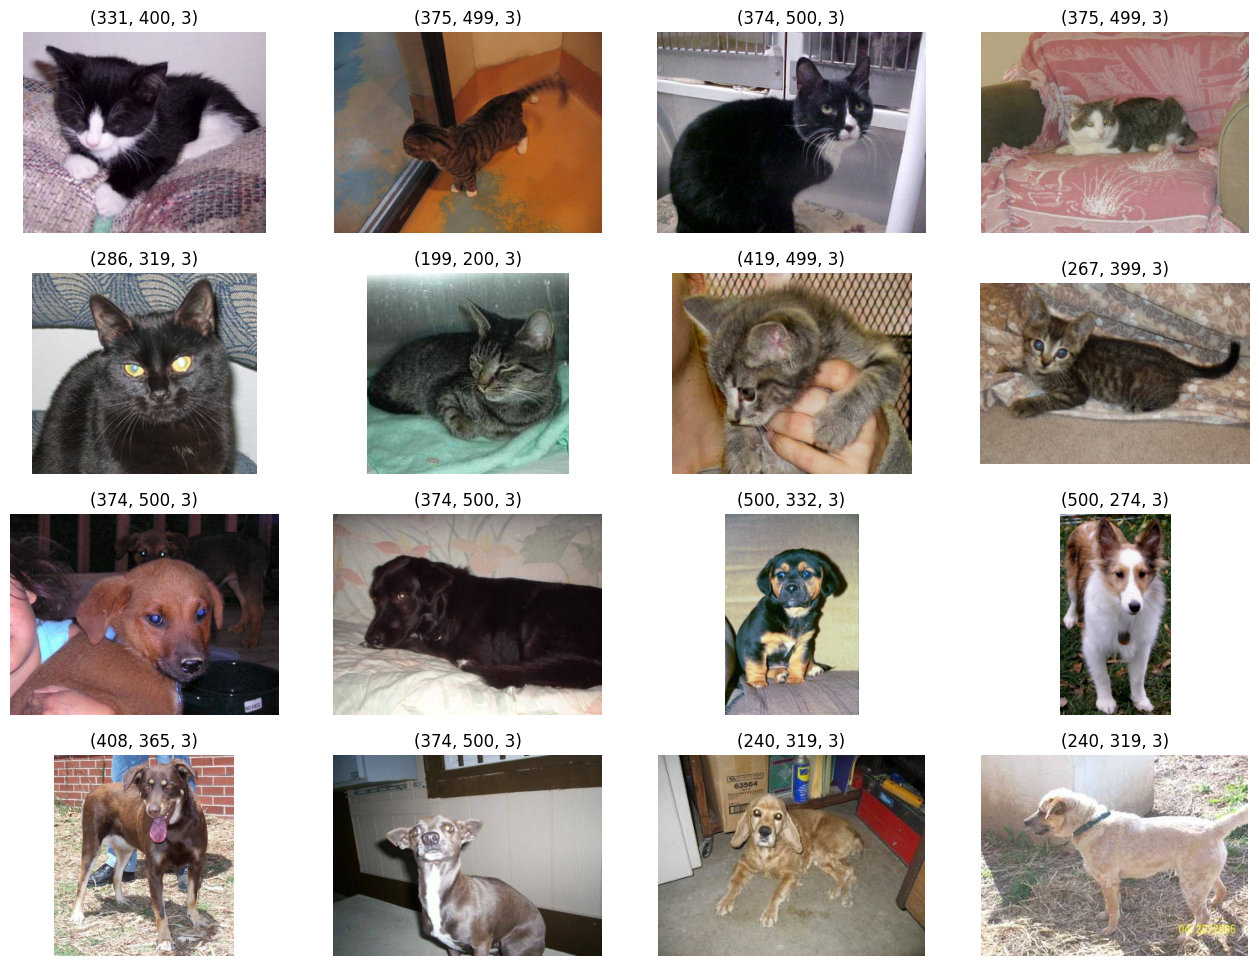

In [9]:
plt.figure(figsize=(16,12))
for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.title(img.shape)
  plt.imshow(img)

### Dataset Characteristics: A More Realistic Challenge

This Cats vs. Dogs dataset introduces some new challenges that make it a more realistic problem than the Fashion-MNIST dataset. However, it still contains a few simplifications.

**Realistic Challenges:**
* **Variable image sizes:** Unlike MNIST, the images in this dataset do not all have the same dimensions. This requires a preprocessing step to resize them to a uniform size before they can be fed into the network.
* **Background Clutter:** The animal to be classified is not isolated agaisnt a clean background. The images often contain other objects: leashes, necklaces, or furniture that potentially confuse the model. This forces the network to learn to focus on the relevant features of the cat or dog.

**Simplifying factors:**
* **Centered Subjects:** In most of the images, the animal appears in the center of the frame.
* **Dominant Subjects:** The cat or the dog typically occupies a large portion of the image area.

These factors make the task slightly easier than a true "in-the-wild" classification problem, where the subject could be small, off-center, or partially obscured.

### 3. Defining the baseline model


Let's consider a three stage CNN with the following architectural choices:

1.   Input image size: All images resized to 150x150 pixels.
2.   Convolutional blocks: The model will have three stages, each with a convolutional and a max-pooling layer.
3.   Filter progression: 16 kernels -> 32 kernels -> 64 kernels
4.   Kernel size = 3x3.
5.   Default stride and padding (stride=1, no-padding).
6.   Pooling 2x2 with default stride (stride=2).

This increasing number of filters in deeper layer is a typical strategy in CNNs allowing the network to learn a hierarchy of features.

In [10]:
model = tf.keras.Sequential()

# Input: (150,150,3)
model.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='valid',
                                 activation='relu',
                                 name='conv1',
                                 input_shape=(150, 150, 3)))

# (148,148,16)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       strides=(2, 2)))

# (74,74,16)
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', name='conv2'))

# (72,72,32)
model.add(tf.keras.layers.MaxPooling2D(2))

# (36,36,32)
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu', name='conv3'))

# (34,34,64)
model.add(tf.keras.layers.MaxPooling2D(2))

# (17,17,64)
model.add(tf.keras.layers.Flatten())

# 17 x 17 x 64 = 18496
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

### CNN vs. MLP: Parameter Comparison

To appreciate the efficiency of CNNs, let's contrast our proposed architecture with an MLP designed for the same task.

An MLP requires the input image to be flattened into a single vector. For our 150x150 color images, this would create flattened vector with 150x150x3 = 67.500 neurons. If we were to connect this to a modest hidden layer of 512 neurons, the number of weights for that layer alone would be approximately 34 million.

In contrast, our RNN architecture preserves and utilizes the spatial information throughout its convolutional layer. As a result, even a much deeper and more powerful CNN can solve the problem with significantly fewer parameters, leading to better performance and more efficient training.

In [12]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['acc'])

### 4. Preprocessing: Datagenerators

As we've discussed, it's often impractical to load an entire image dataset into memory. The standard approach is to load the data in batches directly from the disk during training using Python generators.

In TensorFlow the `imageDatagenerator` reads a batch of images from disk, processes them, and feeds them to the model for each training step. This is incredibly memory-efficient. Additionally, it automatically infers that any image in the `cats`subfolder belongs to the `cat`class and so on, creating labels on the fly. Of course, it performs the scaling preprocessing and data augmentation.

DataGenerators need the following parameters:
* Image files path.
* Batch size.
* The images cropping size.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 5. Model training

Remember always to use early stopping:

In [16]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

An accuracy around 70% can be obtained:

In [17]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    callbacks=[es_callback])

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - acc: 0.4939 - loss: 0.7356 - val_acc: 0.5420 - val_loss: 0.6598
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.6319 - loss: 0.6459 - val_acc: 0.6740 - val_loss: 0.5886
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.6747 - loss: 0.5926 - val_acc: 0.7100 - val_loss: 0.5782
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.7577 - loss: 0.5026 - val_acc: 0.6450 - val_loss: 0.6853
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - acc: 0.7743 - loss: 0.4676 - val_acc: 0.7190 - val_loss: 0.5769
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.8487 - loss: 0.3415 - val_acc: 0.7420 - val_loss: 0.5931
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.9156 - loss: 0.2295 - val_acc: 0.7310 - val_loss: 0.6433
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.9312 - loss: 0.1643 - val_acc: 0.7300 - val_loss: 0.7629
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc

In [31]:
test_loss, test_acc = model.evaluate(validation_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.7289 - loss: 0.5497


### 6. Kernels visualization

Convolutional and Pooling layers are not just abstract matrematical operations: they are powerful feature extractors. The output of each filter, known as feature map or activation map, is essentially a new image that highlights a specific pattern (like an edge, a curve, a texture) was detected in the input.

We can create a function that takes an image as input and output the activations from the convolutional and pooling layers in out trained model.

In [18]:
def visualize_feature_map(model, layer_name, imagen):
  layer_dict = {layer.name : layer for layer in model.layers}
  modelslice = tf.keras.Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)
  feature_maps = modelslice.predict(imagen)
  return feature_maps

Take an image from the dataset and convert it into a batch.

In [19]:
img_path = os.path.join(train_dogs_dir, train_dog_files[0])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)                                       # Numpy array (150, 150, 3)
image = np.expand_dims(x, axis=0)                           # Numpy array with shape (1, 150, 150, 3)
image /= 255
image.shape

(1, 150, 150, 3)

Inspecting `conv_1` layer output (16 kernels, 16 outputs):

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


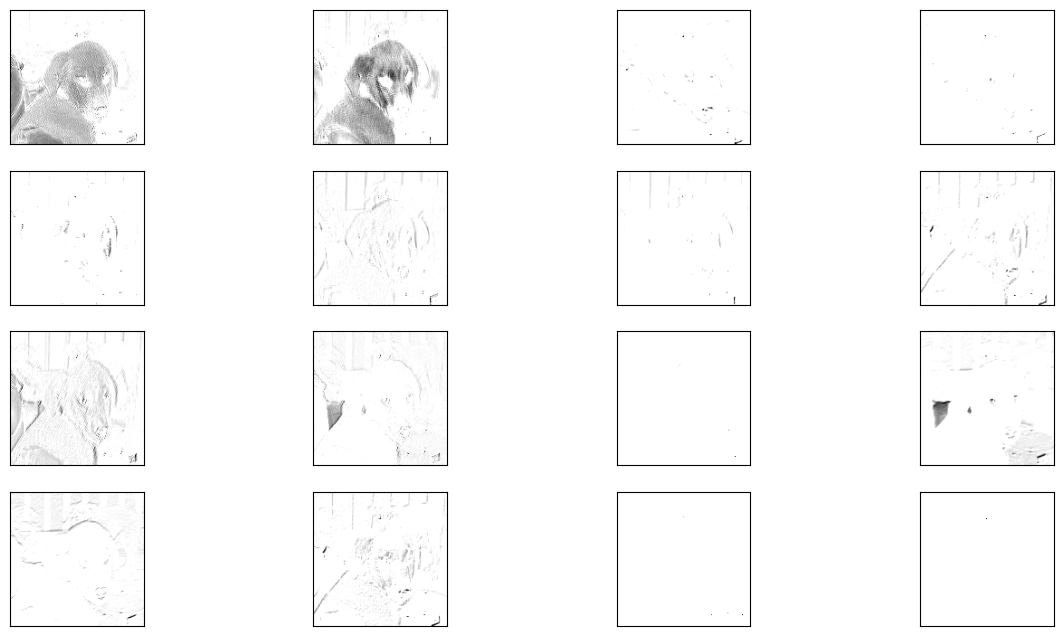

In [20]:
feature_maps = visualize_feature_map(model, 'conv1', image)

plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0, :, :, i-1], cmap=plt.cm.binary)

### 7. Overfitting evidences

Let's represent the evolution of the error function during the training process. Watch for the point where the training accuracy continues to improve, while the validation accuracy flattens or decreases. this divergence between the training and validation curves is the clasic sign of overfitting.

The following plot clearly show the problem. The validation loss starts to increase around epoch 4-5. Our model is beginning to memorize the training data instead of learning to generalize.

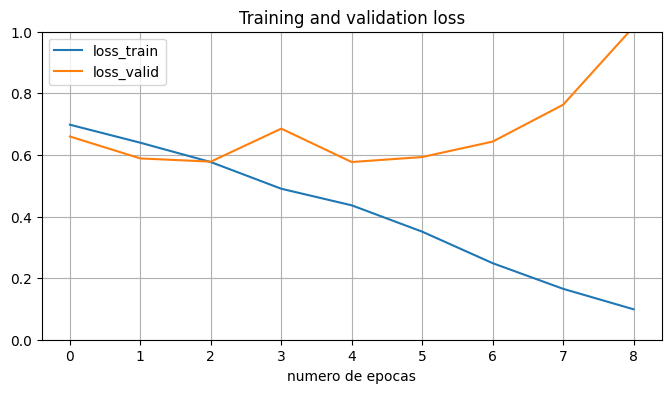

In [21]:
pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,1)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

### 8. Data augmentation + DropOut

Let's define new generators to perform the augmentation transformations: rotations, hifts, flips and zooms and the flows to the dataset directories:

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


For learning purposes, a new model will be defined using the functional API. To combine augmentation with drop-out we have added a new layer between the dense layers in the MLP stage.

In [25]:
img_input = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Convolution2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(img_input, output)

In [26]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['acc'])

In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [28]:
history_2 = model_2.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      callbacks=[es_callback])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - acc: 0.4872 - loss: 0.7055 - val_acc: 0.5010 - val_loss: 0.6969
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - acc: 0.5501 - loss: 0.6864 - val_acc: 0.6040 - val_loss: 0.6809
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - acc: 0.5602 - loss: 0.6825 - val_acc: 0.5990 - val_loss: 0.6752
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - acc: 0.6019 - loss: 0.6700 - val_acc: 0.6490 - val_loss: 0.6401
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - acc: 0.6206 - loss: 0.6609 - val_acc: 0.6440 - val_loss: 0.6268
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - acc: 0.6319 - loss: 0.6441 - val_acc: 0.6890 - val_loss: 0.5877
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - acc: 0.6271 - loss: 0.6456 - val_acc: 0.6890 - val_loss: 0.5850
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - acc: 0.6869 - loss: 0.6029 - val_acc: 0.7020 - val_loss: 0.5641
Epoch 9/30
100/100 ━━━━━━━━━━━━━

The effect is dramtic. the training and validation curves now track each other very closely, indicating that the model is generalizing. Thanks to this effect we are able to delay the overfitting appearance, allowing to train during more epochs.

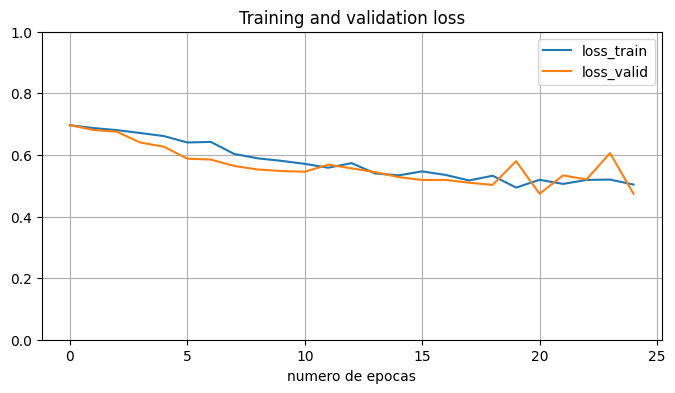

In [29]:
pd.DataFrame({'loss_train': history_2.history['loss'],
              'loss_valid': history_2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,1)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

### Model evaluation

In [30]:
test_loss, test_acc = model_2.evaluate(validation_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.7460 - loss: 0.5085


### Comparing the results

Let's compare the final validation accuracy of our three models to see the impact of each technique.


|Model | Max Validation Accuracy |
|:-:|:-:|
|Baseline|72.9%|
|Dropout + Augmentation|74.6%|